1. Preparação do Ambiente

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import os
import cv2
import seaborn as sns

from datetime import datetime
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from transformers import ViTForImageClassification, SwinForImageClassification
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold




In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/content/drive/MyDrive/Mono1/Datasets'

real = "../content/drive/MyDrive/Mono1/Datasets/real_and_fake_face_detection/real_and_fake_face/training_real/"
fake = "../content/drive/MyDrive/Mono1/Datasets/real_and_fake_face_detection/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

Vizualização do dataset (Faces reais e fakes)

In [15]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

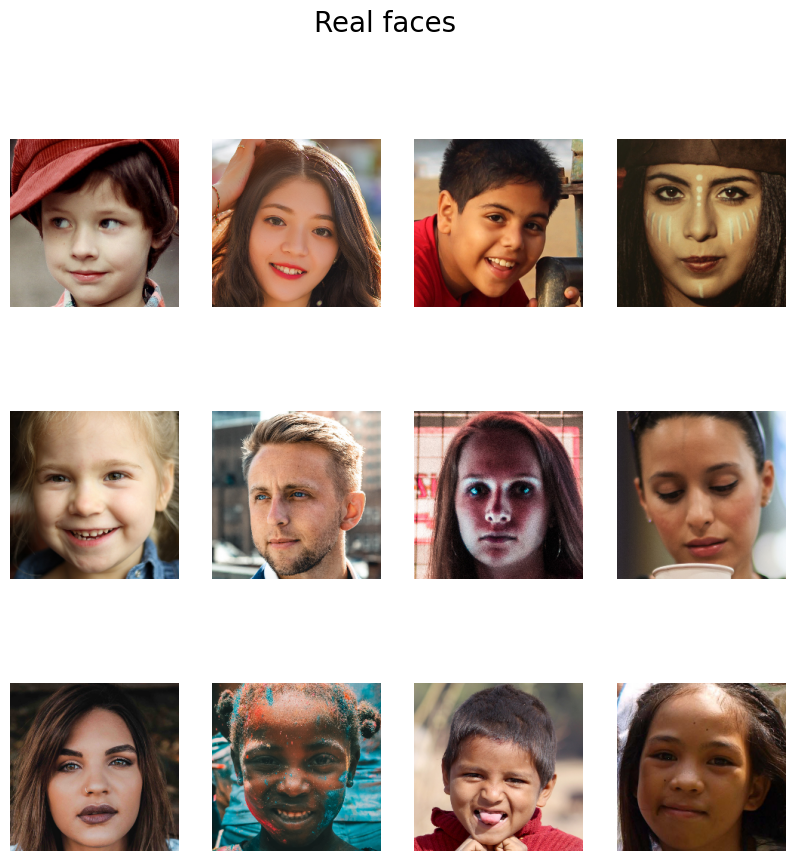

In [16]:
fig = plt.figure(figsize=(10, 10))

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

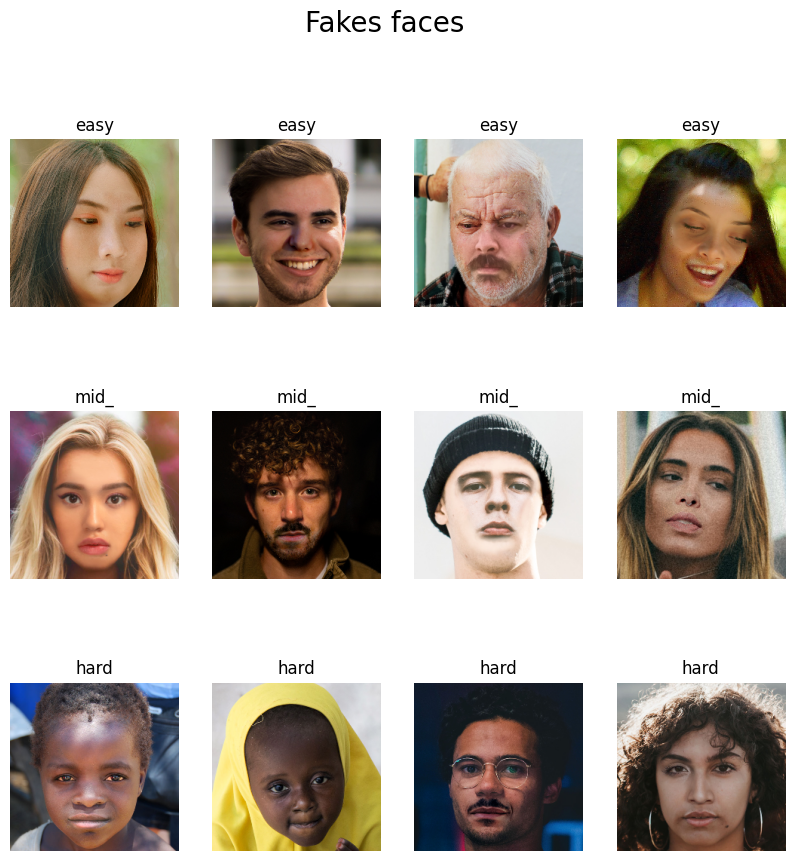

In [17]:
# Filtre as imagens por categoria
easy_images = [img for img in fake_path if 'easy' in img]
mid_images = [img for img in fake_path if 'mid' in img]
hard_images = [img for img in fake_path if 'hard' in img]

# Combine todas as imagens em uma única lista para exibição
selected_images = easy_images[:4] + mid_images[:4] + hard_images[:4]  # Exibe 4 de cada categoria

fig = plt.figure(figsize=(10, 10))

for i in range(len(selected_images)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(load_img(fake + selected_images[i]), cmap='gray')
    plt.suptitle("Fakes faces", fontsize=20)
    plt.title(selected_images[i][:4])
    plt.axis('off')

plt.show()

2. Transformações geométricas nas imagens

In [18]:
input_size = 224
# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Inicializando Image dataset (ImageFolder)

In [19]:
print("Incializando Datasets ...")
# Criar conjuntos de dados de treinamento e validação
# Inserir código
# Criar um dicionario com os dataset para treino e test
image_datasets = {
    'train':
datasets.ImageFolder(root=os.path.join(data_dir, 'real_and_fake_face'), transform=data_transforms['train']),
    'test':
datasets.ImageFolder(root=os.path.join(data_dir, 'real_and_fake_face'), transform=data_transforms['test'])
}

Incializando Datasets ...


Particionar o conjunto de treino em treino e validacão

In [20]:
# conjunto de treino é divido em treino (80%) e validação (20%)
train_dataset_split, val_dataset_split = torch.utils.data.random_split(image_datasets['train'], [0.8, 0.2])

# é adicionado no dicionario image_datasets o conjunto de validação e o conjunto de treino é atualizado
image_datasets['val'] = val_dataset_split
image_datasets['train'] = train_dataset_split

Declarar device

In [21]:
# Detectar a disponibilidade de uma GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Função de perda Balanceada

In [23]:
# Extrair classes do dataset de treinamento
train_labels = [label for _, label in image_datasets['train']]

# Calcular os pesos de classe
class_counts = torch.bincount(torch.tensor(train_labels))
class_weights = torch.tensor([len(train_labels) / (2 * count) for count in class_counts])
class_weights = class_weights.to(device)

Carregando Dataloader

In [24]:
# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Criar dataloaders de treinamento e validação
# utilizar um dicionario para o dataloader dos conjunto de train, val e test
dataloaders_dict = {
    'train':
  DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=0),
    'test':
  DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=0),
    'val':
  DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=0),
}

# Detectar a disponibilidade de uma GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Verificação

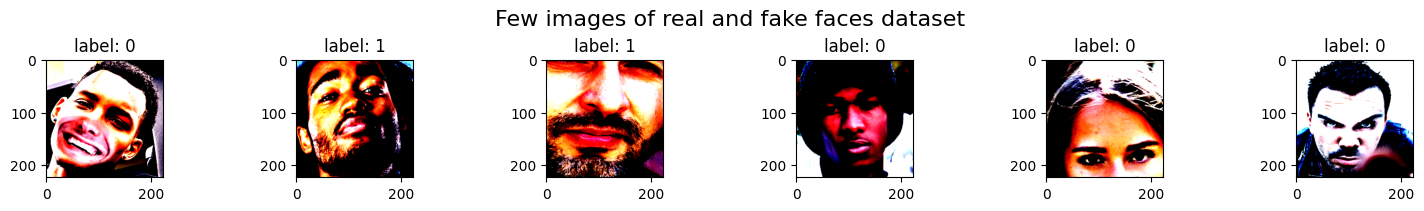

In [25]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 6
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of real and fake faces dataset", fontsize=16)
for x, y in dataloaders_dict['train']:
  for i in range(nb_digits_to_display):
    ax[i].imshow(np.transpose(x[i].numpy(), (1,2,0)), cmap = 'gray')
    ax[i].set_title(f"label: {y[i].numpy()}")
  break

Funções de treino e predição

Função que grafica as funções de perda(custo) do treino e da validação

In [ ]:
#def plot_losses(train_losses, test_losses):
#    plt.plot(train_losses, label = 'train loss')
#    plt.plot(test_losses, label = 'test loss')
#    plt.legend()
#    plt.show()

3. Preparar os Modelos

In [26]:
# Carregar modelos pré-treinados com os pesos corretos
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)  # Usando os pesos corretos
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)  # Usando os pesos corretos
vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
swin = SwinForImageClassification.from_pretrained('microsoft/swin-base-patch4-window7-224')


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 160MB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

In [27]:
print(resnet)
print('-----------------------------------------------------------------')
print(efficientnet)
print('-----------------------------------------------------------------')
print(vit)
print('-----------------------------------------------------------------')
print(swin)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

4. Modificar a Última Camada

In [28]:


num_classes = 2  # Set the number of output classes

def modify_model(model, num_classes):
    if isinstance(model, models.ResNet):
        # Modify the fully connected layer for ResNet
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

    elif isinstance(model, models.EfficientNet):
        # For torchvision's EfficientNet, modify the `classifier` layer
        in_features = model.classifier[1].in_features  # classifier is a Sequential layer
        model.classifier[1] = nn.Linear(in_features, num_classes)

    elif isinstance(model, ViTForImageClassification):
        # Modify the classifier for ViT
        model.config.num_labels = num_classes
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)

    elif isinstance(model, SwinForImageClassification):
        # Modify the classifier for Swin
        model.config.num_labels = num_classes
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)

    return model

# Now modify each model as needed
resnet = modify_model(resnet, num_classes)
efficientnet = modify_model(efficientnet, num_classes)
vit = modify_model(vit, num_classes)
swin = modify_model(swin, num_classes)



Função para plotar matrix confusão

In [29]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()


5. Configurar o Treinamento

In [30]:
def train_model(model, dataloaders, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Adicionar lista para capturar y_true e y_pred
    all_y_true = []
    all_y_pred = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds_train = 0
        total_train = 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Para modelos transformers, precisamos acessar os logits diretamente
            if isinstance(outputs, dict):
                logits = outputs['logits']
            else:
                logits = outputs

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(logits, 1)
            correct_preds_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss_train = running_loss / len(dataloaders['train'].dataset)
        train_acc = correct_preds_train / total_train

        train_losses.append(epoch_loss_train)
        train_accuracies.append(train_acc)

        # Validação
        model.eval()
        val_loss = 0.0
        correct_preds_val = 0
        total_val = 0

        # Adicionar listas temporárias para capturar y_true e y_pred da validação
        epoch_y_true = []
        epoch_y_pred = []

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                if isinstance(outputs, dict):
                    logits = outputs['logits']
                else:
                    logits = outputs

                loss = criterion(logits, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(logits, 1)
                correct_preds_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                # Armazenar rótulos verdadeiros e predições
                epoch_y_true.extend(labels.cpu().numpy())
                epoch_y_pred.extend(predicted.cpu().numpy())

        epoch_loss_val = val_loss / len(dataloaders['val'].dataset)
        val_acc = correct_preds_val / total_val

        val_losses.append(epoch_loss_val)
        val_accuracies.append(val_acc)

        # Adicionar os y_true e y_pred da validação ao final do epoch
        all_y_true.extend(epoch_y_true)
        all_y_pred.extend(epoch_y_pred)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss_train:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Loss: {epoch_loss_val:.4f}, Val Acc: {val_acc:.4f}")

    # Plotar as perdas e acurácias após o treino
    plot_losses(train_losses, val_losses)
    plot_accuracies(train_accuracies, val_accuracies)

    # Gerar a matriz de confusão após o último epoch
    plot_confusion_matrix(all_y_true, all_y_pred)





FUNÇÕES DE PLOTAGEM DE GRÁFICOS

In [31]:
def plot_losses(train_losses, val_losses):
    """Função para plotar train_loss vs val_loss."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss vs Validation Loss')
    plt.legend()
    plt.show()

In [32]:
def plot_accuracies(train_accuracies, val_accuracies):
    """Função para plotar train_acc vs val_acc."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy vs Validation Accuracy')
    plt.legend()
    plt.show()

6. Avaliar o Modelo

In [33]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if isinstance(outputs, dict):
                outputs = outputs['logits']

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    report = classification_report(all_labels, all_preds, zero_division=1, digits=4)
    print(report)

Resnet50

Epoch 1/10, Train Loss: 0.6759, Train Acc: 0.5720, Val Loss: 0.6576, Val Acc: 0.6103
Epoch 2/10, Train Loss: 0.6217, Train Acc: 0.6699, Val Loss: 0.6454, Val Acc: 0.6422
Epoch 3/10, Train Loss: 0.5566, Train Acc: 0.7263, Val Loss: 0.6091, Val Acc: 0.6667
Epoch 4/10, Train Loss: 0.4715, Train Acc: 0.7851, Val Loss: 0.6165, Val Acc: 0.6814
Epoch 5/10, Train Loss: 0.4271, Train Acc: 0.7961, Val Loss: 0.5901, Val Acc: 0.6985
Epoch 6/10, Train Loss: 0.4153, Train Acc: 0.8028, Val Loss: 0.6075, Val Acc: 0.6838
Epoch 7/10, Train Loss: 0.3627, Train Acc: 0.8383, Val Loss: 0.5981, Val Acc: 0.7206
Epoch 8/10, Train Loss: 0.3313, Train Acc: 0.8567, Val Loss: 0.6903, Val Acc: 0.6936
Epoch 9/10, Train Loss: 0.3012, Train Acc: 0.8683, Val Loss: 0.6757, Val Acc: 0.6740
Epoch 10/10, Train Loss: 0.2658, Train Acc: 0.8898, Val Loss: 0.5716, Val Acc: 0.7181


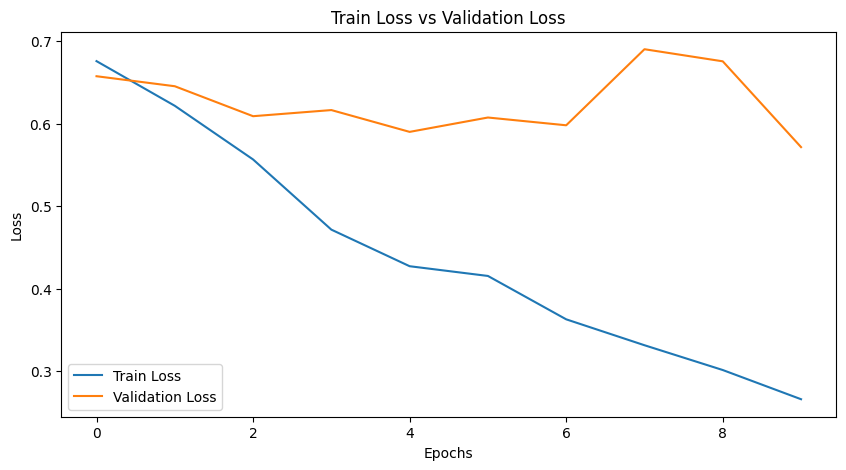

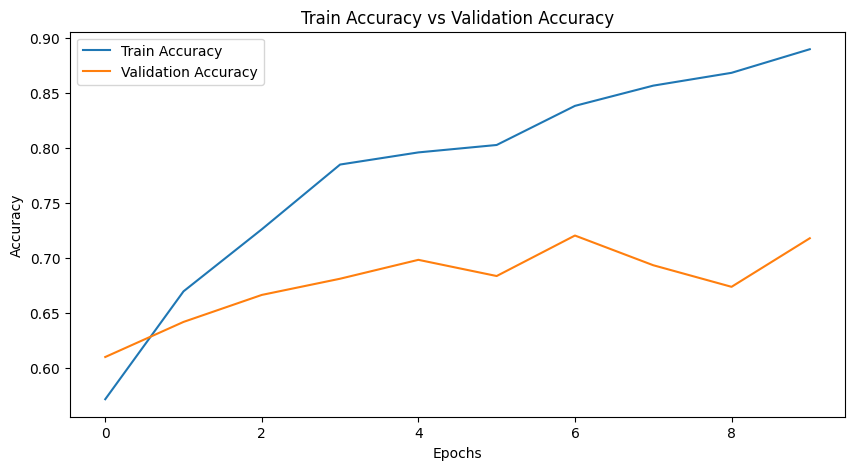

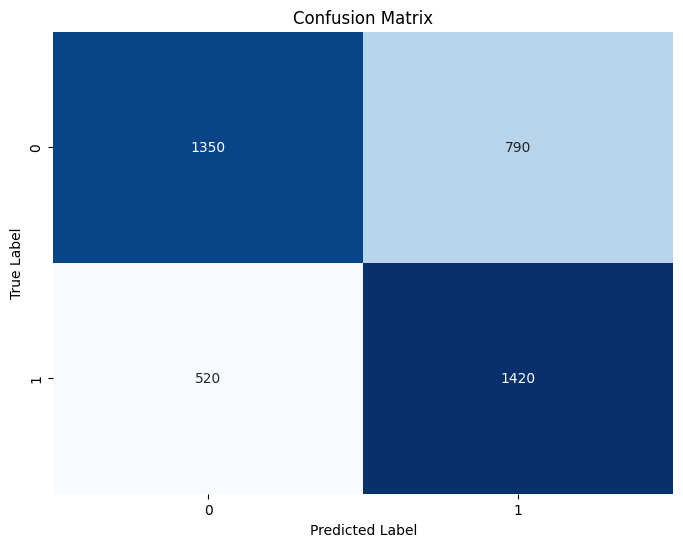





Accuracy: 0.6985
              precision    recall  f1-score   support

           0     0.7542    0.6308    0.6870       214
           1     0.6550    0.7732    0.7092       194

    accuracy                         0.6985       408
   macro avg     0.7046    0.7020    0.6981       408
weighted avg     0.7070    0.6985    0.6976       408



In [34]:
train_model(resnet, dataloaders_dict, 10)
print("\n\n\n")
# Avaliar os modelos
evaluate_model(resnet, dataloaders_dict)

Efficientnet

Epoch 1/10, Train Loss: 0.6902, Train Acc: 0.5150, Val Loss: 0.6556, Val Acc: 0.6225
Epoch 2/10, Train Loss: 0.6265, Train Acc: 0.6626, Val Loss: 0.6321, Val Acc: 0.6324
Epoch 3/10, Train Loss: 0.5679, Train Acc: 0.7006, Val Loss: 0.5713, Val Acc: 0.7206
Epoch 4/10, Train Loss: 0.4981, Train Acc: 0.7544, Val Loss: 0.5610, Val Acc: 0.7304
Epoch 5/10, Train Loss: 0.4300, Train Acc: 0.7893, Val Loss: 0.5376, Val Acc: 0.7426
Epoch 6/10, Train Loss: 0.3869, Train Acc: 0.8224, Val Loss: 0.5960, Val Acc: 0.7083
Epoch 7/10, Train Loss: 0.3371, Train Acc: 0.8512, Val Loss: 0.4905, Val Acc: 0.7770
Epoch 8/10, Train Loss: 0.3156, Train Acc: 0.8549, Val Loss: 0.5408, Val Acc: 0.7574
Epoch 9/10, Train Loss: 0.2905, Train Acc: 0.8677, Val Loss: 0.4724, Val Acc: 0.7647
Epoch 10/10, Train Loss: 0.2815, Train Acc: 0.8812, Val Loss: 0.5338, Val Acc: 0.7696


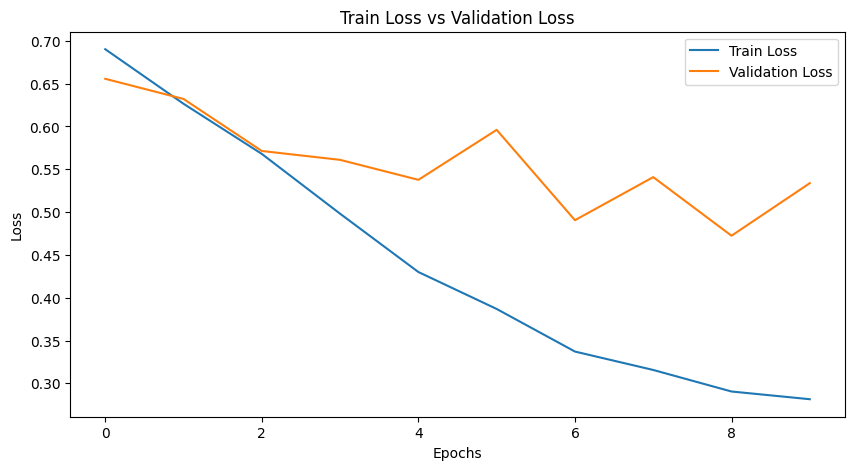

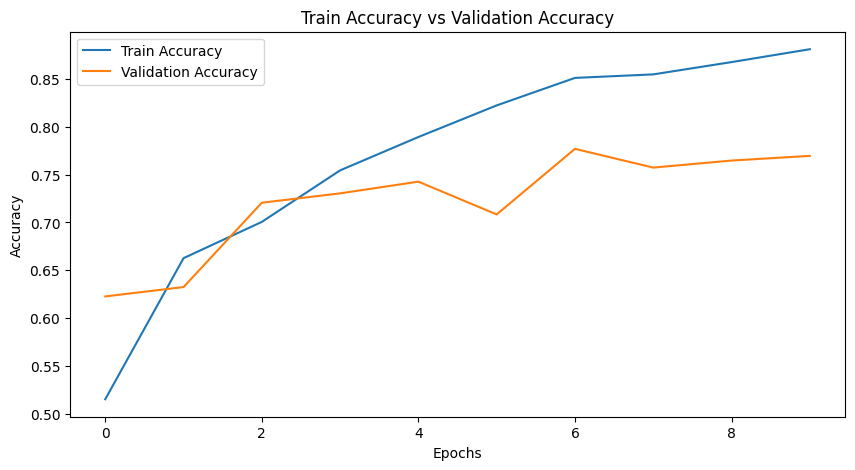

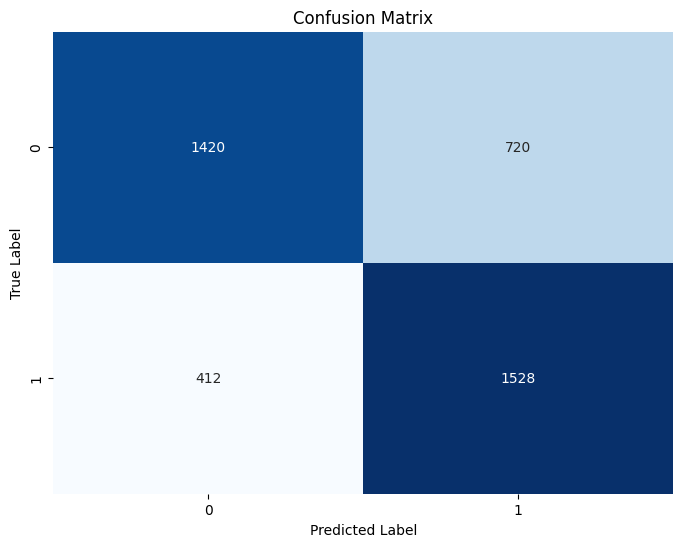





Accuracy: 0.7549
              precision    recall  f1-score   support

           0     0.8239    0.6776    0.7436       214
           1     0.7026    0.8402    0.7653       194

    accuracy                         0.7549       408
   macro avg     0.7632    0.7589    0.7544       408
weighted avg     0.7662    0.7549    0.7539       408



In [35]:
train_model(efficientnet, dataloaders_dict, 10)
print("\n\n\n")
# Avaliar os modelos
evaluate_model(efficientnet, dataloaders_dict)

ViT

Epoch 1/10, Train Loss: 0.6936, Train Acc: 0.5254, Val Loss: 0.6755, Val Acc: 0.5809
Epoch 2/10, Train Loss: 0.6314, Train Acc: 0.6479, Val Loss: 0.7168, Val Acc: 0.5784
Epoch 3/10, Train Loss: 0.5267, Train Acc: 0.7391, Val Loss: 0.5250, Val Acc: 0.7402
Epoch 4/10, Train Loss: 0.4881, Train Acc: 0.7789, Val Loss: 0.4855, Val Acc: 0.7623
Epoch 5/10, Train Loss: 0.3982, Train Acc: 0.8181, Val Loss: 0.4784, Val Acc: 0.7721
Epoch 6/10, Train Loss: 0.3124, Train Acc: 0.8757, Val Loss: 0.4763, Val Acc: 0.7647
Epoch 7/10, Train Loss: 0.2936, Train Acc: 0.8824, Val Loss: 0.4690, Val Acc: 0.7917
Epoch 8/10, Train Loss: 0.2670, Train Acc: 0.8867, Val Loss: 0.5304, Val Acc: 0.7598
Epoch 9/10, Train Loss: 0.2432, Train Acc: 0.9039, Val Loss: 0.4548, Val Acc: 0.7917
Epoch 10/10, Train Loss: 0.1924, Train Acc: 0.9271, Val Loss: 0.5487, Val Acc: 0.7745


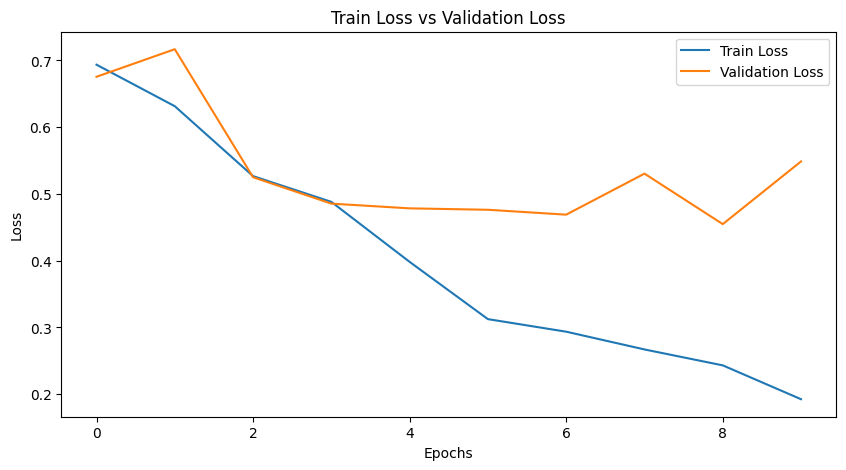

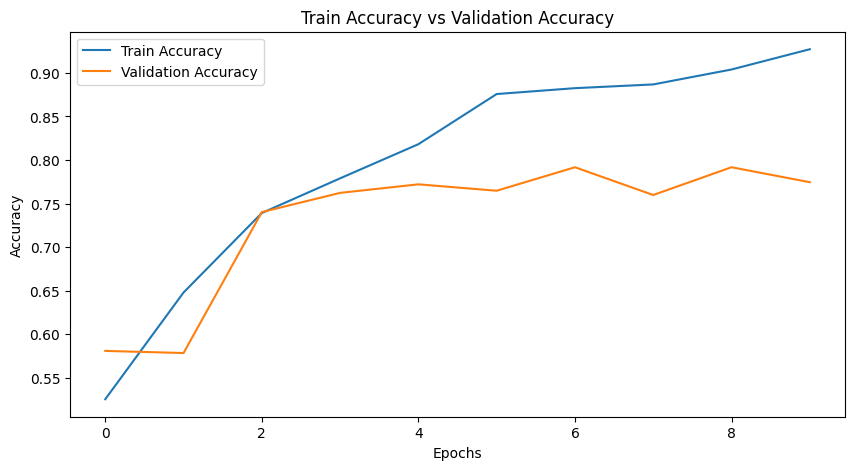

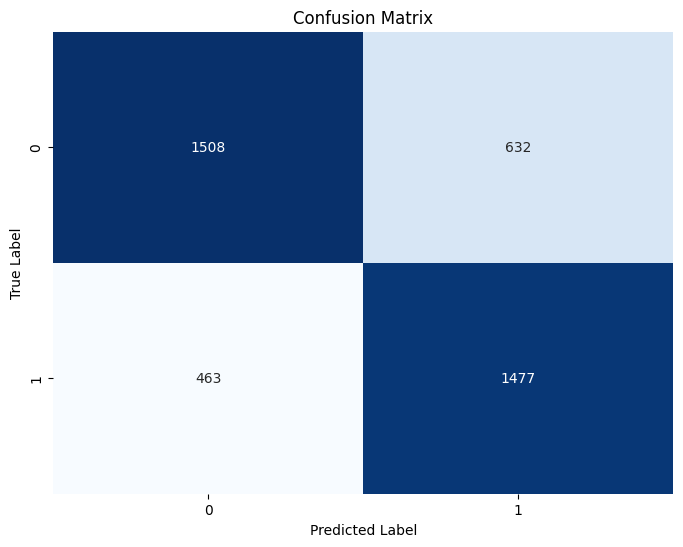





Accuracy: 0.7647
              precision    recall  f1-score   support

           0     0.7837    0.7617    0.7725       214
           1     0.7450    0.7680    0.7563       194

    accuracy                         0.7647       408
   macro avg     0.7643    0.7649    0.7644       408
weighted avg     0.7653    0.7647    0.7648       408



In [36]:
train_model(vit, dataloaders_dict, 10)
print("\n\n\n")
# Avaliar os modelos
evaluate_model(vit, dataloaders_dict)

Swin

Epoch 1/10, Train Loss: 0.6886, Train Acc: 0.5468, Val Loss: 0.6468, Val Acc: 0.5858
Epoch 2/10, Train Loss: 0.6678, Train Acc: 0.5873, Val Loss: 0.6327, Val Acc: 0.6005
Epoch 3/10, Train Loss: 0.5970, Train Acc: 0.6601, Val Loss: 0.6627, Val Acc: 0.5956
Epoch 4/10, Train Loss: 0.5265, Train Acc: 0.7410, Val Loss: 0.6282, Val Acc: 0.6838
Epoch 5/10, Train Loss: 0.4254, Train Acc: 0.7936, Val Loss: 0.7208, Val Acc: 0.6446
Epoch 6/10, Train Loss: 0.3907, Train Acc: 0.8267, Val Loss: 0.5561, Val Acc: 0.7475
Epoch 7/10, Train Loss: 0.3546, Train Acc: 0.8494, Val Loss: 0.4397, Val Acc: 0.7794
Epoch 8/10, Train Loss: 0.3110, Train Acc: 0.8794, Val Loss: 0.6066, Val Acc: 0.7230
Epoch 9/10, Train Loss: 0.2564, Train Acc: 0.8941, Val Loss: 0.5778, Val Acc: 0.7500
Epoch 10/10, Train Loss: 0.3203, Train Acc: 0.8616, Val Loss: 0.4026, Val Acc: 0.8309


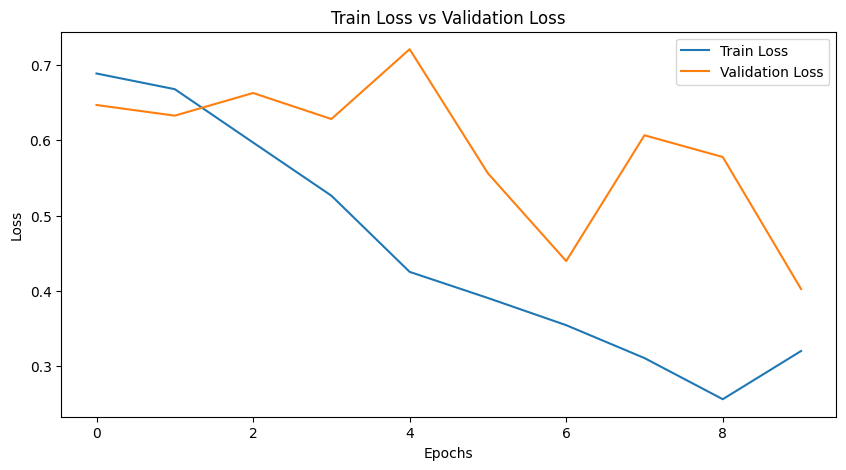

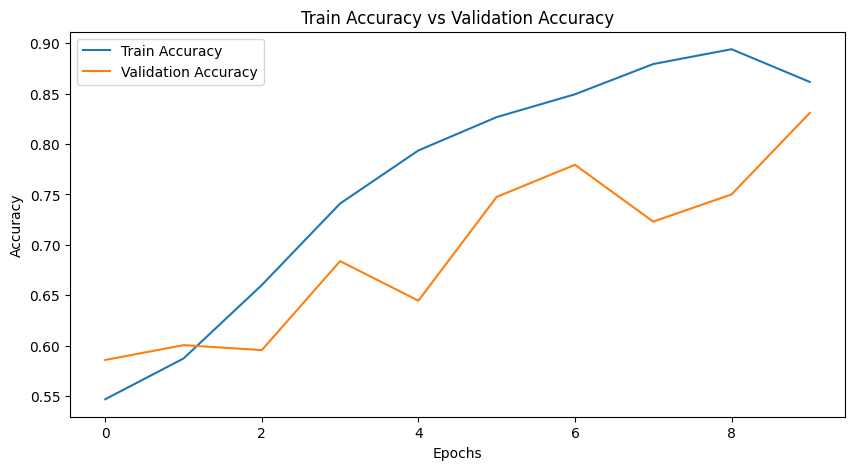

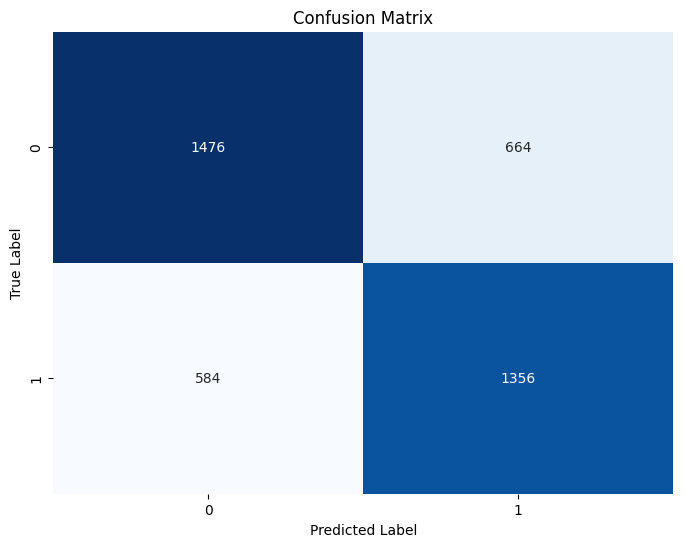





Accuracy: 0.8407
              precision    recall  f1-score   support

           0     0.8782    0.8084    0.8418       214
           1     0.8057    0.8763    0.8395       194

    accuracy                         0.8407       408
   macro avg     0.8419    0.8423    0.8407       408
weighted avg     0.8437    0.8407    0.8407       408



In [37]:
train_model(swin, dataloaders_dict, 10)
print("\n\n\n")
# Avaliar os modelos
evaluate_model(swin, dataloaders_dict)